In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path
from tqdm import tqdm

# Image test

In [ ]:
file_path = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\prueba.tif')

# Read the TIFF file
image = tiff.imread(file_path)

In [ ]:
plt.imshow(image, cmap='gray')

In [ ]:
#sauvola thresholding
from skimage.filters import threshold_sauvola

#apply sauvola thresholding
sauvola_threshold = threshold_sauvola(image, window_size=49, k=0.05)

binary_sauvola_noisy = image < sauvola_threshold

In [ ]:
plt.imshow(binary_sauvola_noisy, cmap='gray')

In [ ]:
#binary remove small objects
from skimage.morphology import remove_small_objects

#label the image
from skimage.measure import label
labeled_image = label(binary_sauvola_noisy)

plt.imshow(labeled_image)

#remove small objects
binary_sauvola = remove_small_objects(labeled_image, min_size=100) > 0

In [ ]:
plt.imshow(binary_sauvola, cmap='gray')

In [ ]:
#plot the original image, the noisy sauvola image and the binary sauvola image in the same figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(binary_sauvola_noisy, cmap='gray')
ax[1].set_title('Noisy Sauvola Image')
ax[1].axis('off')
ax[2].imshow(binary_sauvola, cmap='gray')
ax[2].set_title('Binary Sauvola Image')
ax[2].axis('off')
plt.tight_layout()
plt.show()


# Volume test

In [ ]:
volume_path  = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\frontal_90right.tif')

# Read the volume
volume = tiff.imread(volume_path)

In [142]:
slide = 5

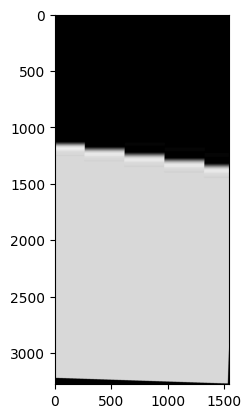

In [143]:
plt.imshow(volume[slide], cmap='gray')

In [144]:
#otsu thresholding
from skimage.filters import threshold_otsu

#apply otsu thresholding
# otsu_threshold = threshold_otsu(volume)

binary_otsu = volume < otsu_threshold

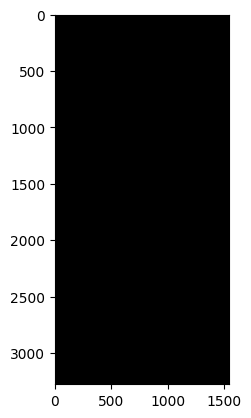

In [145]:
plt.imshow(binary_otsu[slide], cmap='gray')

In [125]:
from joblib import Parallel, delayed

def process_slice(slice_):
    sauvola_threshold = threshold_sauvola(slice_, window_size=49, k=0.05)
    return slice_ < sauvola_threshold

# Apply Sauvola thresholding to each slice in parallel
suavola_noisy = np.array(Parallel(n_jobs=-1)(delayed(process_slice)(volume[i]) for i in tqdm(range(volume.shape[0]))))

100%|██████████| 225/225 [00:08<00:00, 27.69it/s]


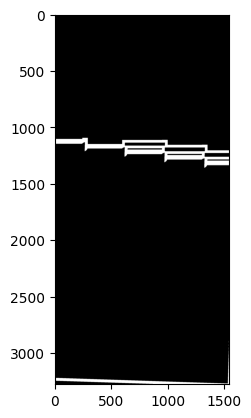

In [146]:
plt.imshow(suavola_noisy[slide], cmap='gray')

In [127]:
#remove small objcets 

def remove_small_objects_slice(slice_):
    labeled_slice = label(slice_)
    return remove_small_objects(labeled_slice, min_size=100) > 0

# Apply small object removal to each slice in parallel
binary_sauvola = np.array(Parallel(n_jobs=-1)(delayed(remove_small_objects_slice)(suavola_noisy[i]) for i in tqdm(range(suavola_noisy.shape[0]))))

100%|██████████| 225/225 [00:01<00:00, 134.42it/s]


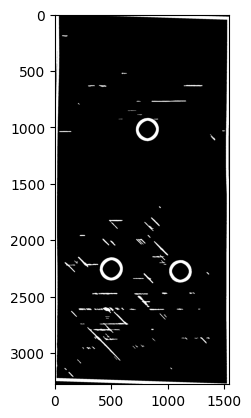

In [135]:
plt.imshow(binary_sauvola[slide], cmap='gray')

# Sauvola full function

In [ ]:
def sauvola_thresholding(volume, window_size=49, k=0.05, min_size=100):
    """
    Apply Sauvola thresholding and remove small objects from a 3D volume.

    Parameters:
    - volume: 3D numpy array
    - window_size: size of the local window for Sauvola thresholding
    - k: parameter for Sauvola thresholding
    - min_size: minimum size of objects to keep

    Returns:
    - binary_volume: 3D binary numpy array after Sauvola thresholding and small object removal
    """

    def sauvola_slice(slice_):
        sauvola_threshold = threshold_sauvola(slice_, window_size=49, k=0.05)
        return slice_ < sauvola_threshold

    def remove_small_objects_slice(slice_):
        labeled_slice = label(slice_)
        return remove_small_objects(labeled_slice, min_size=100) > 0

    # Apply Sauvola thresholding to each slice in parallel
    sauvola_noisy = np.array(Parallel(n_jobs=-1)(delayed(sauvola_slice)(volume[i]) for i in tqdm(range(volume.shape[0]))))

    # Remove small objects from each slice in parallel
    binary_volume = np.array(Parallel(n_jobs=-1)(delayed(remove_small_objects_slice)(sauvola_noisy[i]) for i in tqdm(range(sauvola_noisy.shape[0]))))

    return binary_volume